# Testing things out for the annotation models

This is an experimental notebook. I wanted to find good ways for evaluating NLP models (bag-of-words is used here for simplicity). 

Near the end, I looked at wrapping up all the pre-processing and modelling steps into a single sklearn `Pipeline` object and pickling it. This approach allows models to be saved to a file along with their pre-processing and post-processing steps. They can then be used very simply fit `.predict(X)` calls on new data. 

In [1]:
import pickle
from pathlib import Path

import numpy as np
import pandas as pd
import scipy
import seaborn as sns
import sklearn
import statsmodels
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm as tqdm

# Make graphics nice
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Set sensible defaults
sns.set()
sns.set_style("ticks")
sns.set_context('paper')

In [ ]:
df_train = pd.read_csv('//data2/Documents/a-proof/bow_data/covid_traindata.tsv', sep='\t')
print(df_train.shape)
df_train.head()

In [3]:
df_test = pd.read_csv('//data2/Documents/a-proof/bow_data/covid_testdata.tsv', sep='\t')
df_test.shape

(17365, 6)

In [4]:
# extract all annotated sentences + equal number of random non-annotated sequences
df_has_dom = df_train[~df_train.annotations.isna()]
# df_train = pd.concat([df_has_dom, df_train[df_train.annotations.isna()].sample(100)]) 
df_train = df_has_dom
print(df_train.shape)

# Make initial corpus from train data
corpus = df_train.sentence.values
len(corpus)

(14718, 6)


14718

In [6]:
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer

stop_words = stopwords.words('dutch')

vectorizer = CountVectorizer(
    lowercase=True,
    stop_words=stop_words,
    strip_accents='ascii',
    min_df=0.002,
    max_df=0.9,
)
X_train = vectorizer.fit_transform(corpus)
print('Vocabulary size:', len(vectorizer.vocabulary_))
print('Train:', X_train.shape)

X_test = vectorizer.transform(df_test.sentence.values)
print('Test:', X_test.shape)

Vocabulary size: 479
Train: (14718, 479)
Test: (17365, 479)


In [7]:
train_vocab = vectorizer.vocabulary_
train_vocab

{'passieve': 333,
 'lift': 259,
 'lopen': 271,
 'mogelijk': 292,
 'beweegadvies': 102,
 'starten': 389,
 'stoel': 392,
 'unit': 419,
 '30': 38,
 '25': 32,
 'min': 288,
 'doel': 159,
 'ft': 180,
 'plan': 342,
 'bed': 85,
 'week': 460,
 'respiratoire': 363,
 'insufficientie': 232,
 'covid': 134,
 'voorgeschiedenis': 445,
 'medicatie': 279,
 'beloop': 96,
 'opname': 322,
 'overname': 327,
 'aldaar': 65,
 '27': 34,
 '03': 3,
 'opgenomen': 320,
 'bekend': 94,
 'obesitas': 306,
 'hypertensie': 224,
 'hypercholesterolemie': 223,
 'depressie': 148,
 'gecompliceerd': 185,
 'hit': 217,
 'toename': 407,
 'adequaat': 54,
 'wv': 470,
 'icc': 226,
 'herstart': 211,
 '22': 29,
 '05': 5,
 'verdere': 432,
 'afname': 62,
 'consolidaties': 129,
 'icu': 227,
 'dd': 146,
 '19': 19,
 'pneumonie': 344,
 'behandeling': 91,
 'gedurende': 189,
 'dagen': 145,
 'waarna': 454,
 'langzaam': 255,
 'waarbij': 452,
 'patient': 334,
 'klinisch': 244,
 'heel': 207,
 'herstel': 212,
 'zien': 475,
 'verpleegafdeling': 434

In [8]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.80)
pca = pca.fit(X_train.toarray())
_X_train = pca.transform(X_train.toarray())
_X_test = pca.transform(X_test.toarray())
_X_train.shape, _X_test.shape

((14718, 219), (17365, 219))

In [9]:
df_test.annotations.value_counts().head(10)

type\_Background                                             1890
target                                                        782
info\_Third party                                              68
STM 1 | .B152: Stemming                                        19
.D450: Lopen en zich verplaatsen                               16
STM 0 | .B152: Stemming                                        10
type\_Implicit | .D450: Lopen en zich verplaatsen | FAC 0      10
.B455: Inspanningstolerantie | INS 1                            9
.B455: Inspanningstolerantie | INS 0                            8
lop\_hulpmiddel                                                 7
Name: annotations, dtype: int64

In [10]:
DOMAINS = ['STM', 'INS', 'BER', 'FAC']

def indicate_domain(s, d):
    assert d in DOMAINS
    if not isinstance(s, str):
        return 0
    if d in s:
        return 1
    return 0

def find_level(s, d):
    assert d in DOMAINS
    if not isinstance(s, str):
        return np.nan
    if d in s:
        pos = s.find(d)
        lev = int(s[pos+3:pos+5])
        return lev
    return np.nan

In [ ]:
for df in [df_train, df_test]:
    df['domain'] = np.nan
    for d in DOMAINS:
        df[f"ind_{d}"] = df['annotations'].apply(indicate_domain, d=d)
        df[d] = df['annotations'].apply(find_level, d=d)
        df.loc[~df[d].isna(), 'domain'] = d

df_train.sample(5)

In [12]:
df_train.domain.value_counts(dropna=False)

NaN    13924
STM      360
FAC      244
INS      189
BER        1
Name: domain, dtype: int64

Text(0.5, 1.0, 'Domain class on Covid train data')

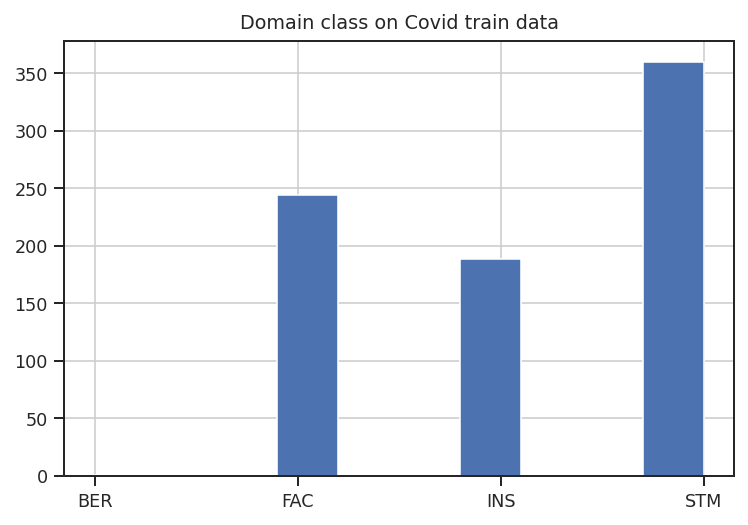

In [13]:
df_train.domain.sort_values().hist()
plt.title('Domain class on Covid train data')

Text(0.5, 1.0, 'Domain class on Covid test data')

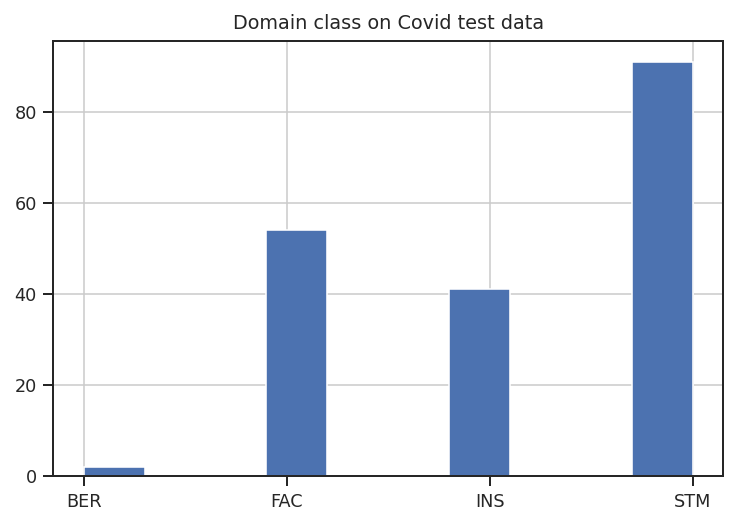

In [14]:
df_test.domain.sort_values().hist()
plt.title('Domain class on Covid test data')

In [15]:
df_test.domain.value_counts(dropna=False)

NaN    17177
STM       91
FAC       54
INS       41
BER        2
Name: domain, dtype: int64

In [16]:
# Count how often domain collision occurs
df_train[~df_train.domain.isna()][['ind_STM', 'ind_INS', 'ind_BER', 'ind_FAC']].sum(axis=1).value_counts()

1    776
2     18
dtype: int64

In [17]:
# Count how often domain collision occurs
df_test[~df_test.domain.isna()][['ind_STM', 'ind_INS', 'ind_BER', 'ind_FAC']].sum(axis=1).value_counts()

1    185
2      3
dtype: int64

In [ ]:
# What are the domain collisions?
df_train[df_train[['ind_STM', 'ind_INS', 'ind_BER', 'ind_FAC']].sum(axis=1) > 1]

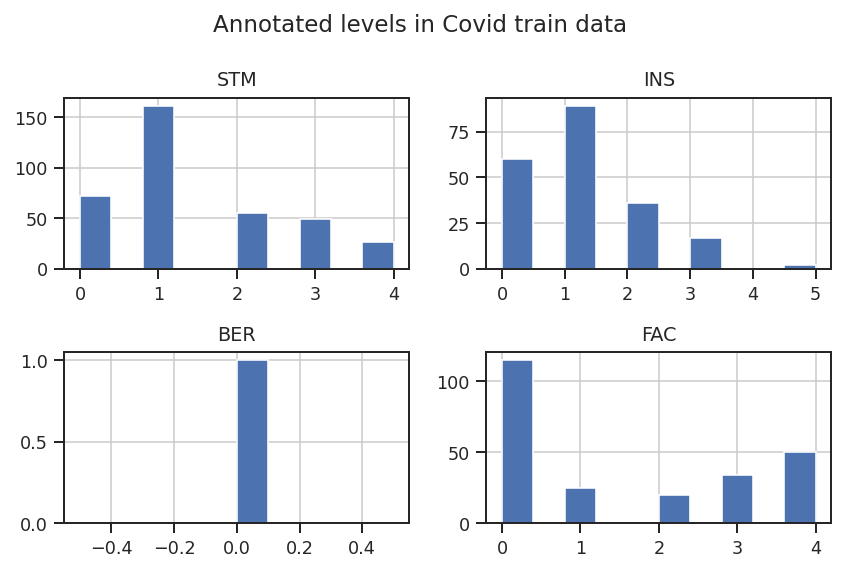

In [19]:
df_train[DOMAINS].hist()
plt.suptitle("Annotated levels in Covid train data")
plt.tight_layout()
plt.show()

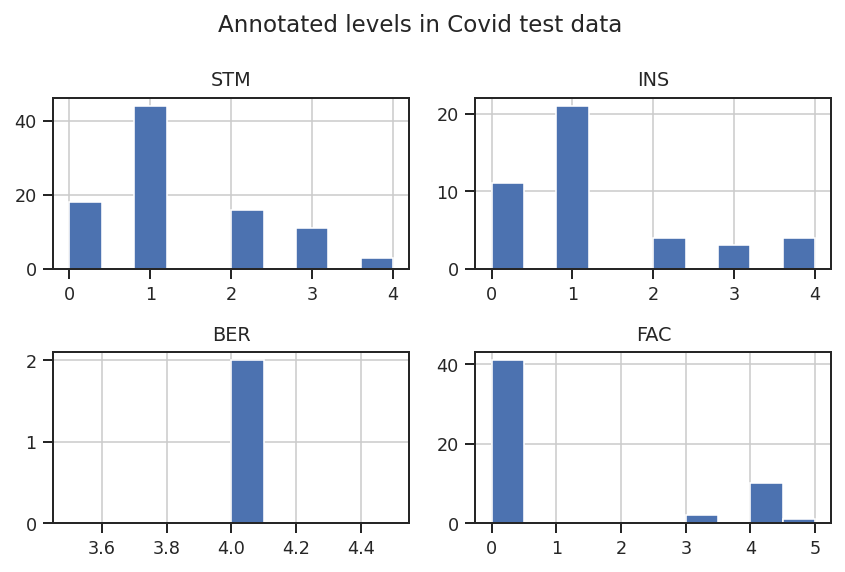

In [20]:
df_test[DOMAINS].hist()
plt.suptitle("Annotated levels in Covid test data")
plt.tight_layout()
plt.show()

In [21]:
from collections import defaultdict

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support as prfs
from sklearn.svm import SVC

results = defaultdict(list)

for target in ['domain']:
    y_train = df_train[target].fillna('none').values
    y_test = df_test[target].fillna('none').values
    for model in [LogisticRegression, RandomForestClassifier]:
        for pca_flag in [True, False]:
            print(f"Model: {model}\tPCA: {pca_flag}")
            
            traindata = _X_train if pca_flag else X_train
            testdata = _X_test if pca_flag else X_test
            mod = model().fit(traindata, y_train)
            preds = mod.predict(testdata)
            acc = accuracy_score(y_test, preds)
            prec, rec, f1, sup = prfs(y_test, preds, zero_division=0)
            
            mod_name = type(mod).__name__
            results['model'].extend([mod_name]*5)
            results['pca'].extend([pca_flag]*5)
            results['class'].extend(mod.classes_)
            results['precision'].extend(prec)
            results['recall'].extend(rec)
            results['f1'].extend(f1)    

df_results = pd.DataFrame(results)
df_results

Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>	PCA: True
Model: <class 'sklearn.linear_model._logistic.LogisticRegression'>	PCA: False
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>	PCA: True
Model: <class 'sklearn.ensemble._forest.RandomForestClassifier'>	PCA: False


,model,pca,class,precision,recall,f1
0,LogisticRegression,True,BER,0.000000,0.000000,0.000000
1,LogisticRegression,True,FAC,0.461538,0.222222,0.300000
2,LogisticRegression,True,INS,0.276596,0.317073,0.295455
3,LogisticRegression,True,STM,0.161290,0.219780,0.186047
4,LogisticRegression,True,none,0.992078,0.991558,0.991818
5,LogisticRegression,False,BER,0.000000,0.000000,0.000000
6,LogisticRegression,False,FAC,0.216867,0.333333,0.262774
7,LogisticRegression,False,INS,0.274510,0.341463,0.304348
8,LogisticRegression,False,STM,0.189873,0.329670,0.240964
9,LogisticRegression,False,none,0.992913,0.986901,0.989898


In [22]:
df_results[df_results.pca==True].set_index(['model', 'pca']).round(4)

class  precision  recall      f1
model                  pca                                  
LogisticRegression     True   BER     0.0000  0.0000  0.0000
                       True   FAC     0.4615  0.2222  0.3000
                       True   INS     0.2766  0.3171  0.2955
                       True   STM     0.1613  0.2198  0.1860
                       True  none     0.9921  0.9916  0.9918
RandomForestClassifier True   BER     0.0000  0.0000  0.0000
                       True   FAC     0.1724  0.2778  0.2128
                       True   INS     0.1364  0.1463  0.1412
                       True   STM     0.1020  0.1648  0.1261
                       True  none     0.9915  0.9863  0.9889

In [23]:
df_results[df_results.pca==False].set_index(['model', 'pca']).round(4)

class  precision  recall      f1
model                  pca                                   
LogisticRegression     False   BER     0.0000  0.0000  0.0000
                       False   FAC     0.2169  0.3333  0.2628
                       False   INS     0.2745  0.3415  0.3043
                       False   STM     0.1899  0.3297  0.2410
                       False  none     0.9929  0.9869  0.9899
RandomForestClassifier False   BER     0.0000  0.0000  0.0000
                       False   FAC     0.1414  0.5185  0.2222
                       False   INS     0.1649  0.3902  0.2319
                       False   STM     0.1093  0.3626  0.1679
                       False  none     0.9939  0.9702  0.9819

In [24]:
from sklearn.multioutput import MultiOutputClassifier

CLASSES = {'BER': 0, 'FAC': 1, 'INS': 2, 'STM': 3, 'none': 4}

y_train = df_train['domain'].fillna('none')
y_train = y_train.map(CLASSES)
y_test = df_test['domain'].fillna('none')
y_test = y_test.map(CLASSES)

train_level = df_train[DOMAINS].sum(axis=1)
test_level = df_test[DOMAINS].sum(axis=1)


Y_train = np.vstack([y_train, train_level]).T
Y_test = np.vstack([y_test, test_level]).T

print(y_train.shape, train_level.shape, Y_train.shape)
print(y_test.shape, test_level.shape, Y_test.shape)

annotator_model = MultiOutputClassifier(
    RandomForestClassifier(n_estimators=20),
    n_jobs = 4,
)


annotator_model = annotator_model.fit(X_train, Y_train)
preds = annotator_model.predict(X_test)
preds.shape

(14718,) (14718,) (14718, 2)
(17365,) (17365,) (17365, 2)


(17365, 2)

In [25]:
preds

array([[4., 0.],
       [4., 0.],
       [4., 0.],
       ...,
       [4., 0.],
       [4., 0.],
       [4., 0.]])

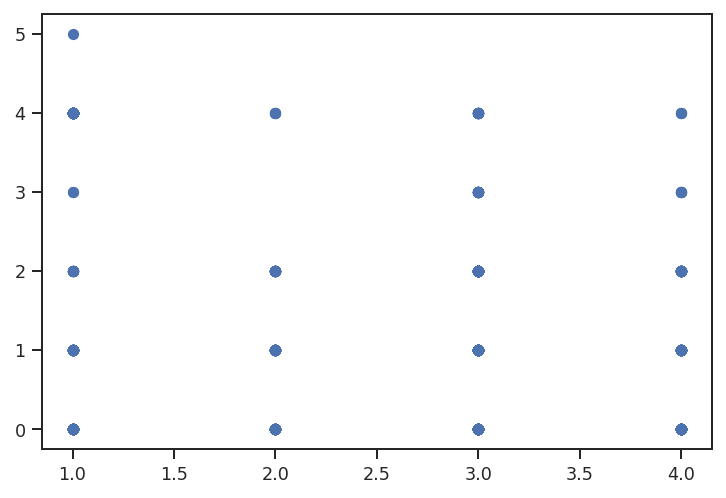

In [26]:
plt.scatter(preds[:, 0], preds[:, 1])

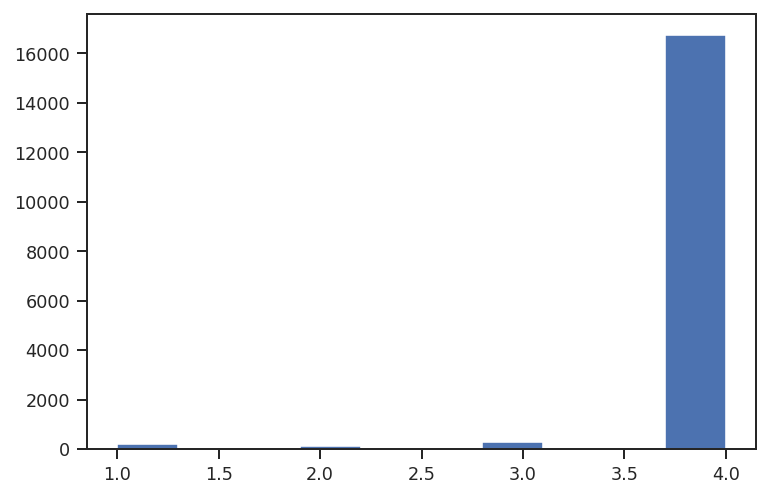

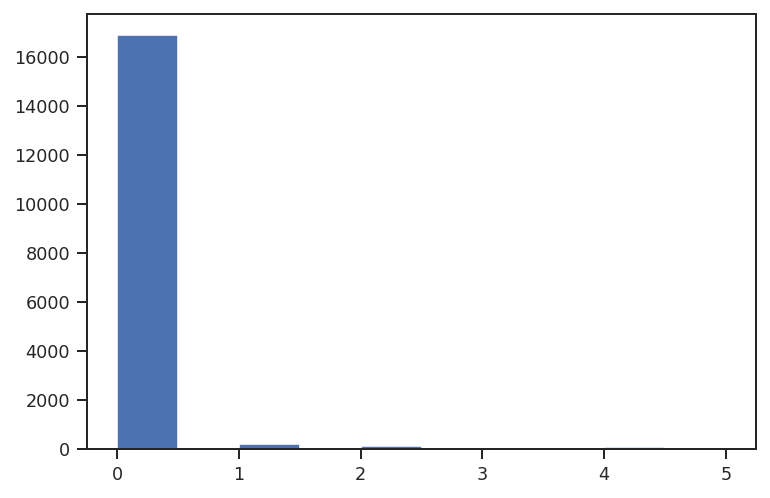

In [27]:
plt.hist(preds[:, 0])
plt.show()
plt.hist(preds[:, 1])
plt.show()

In [28]:
df_ev = pd.DataFrame(preds, columns=['domain', 'level'])
df_ev['domain'] = df_ev['domain'].astype(np.int64)
df_ev

,domain,level
0,4,0.0
1,4,0.0
2,4,0.0
3,4,0.0
4,4,0.0
...,...,...
17360,4,0.0
17361,3,0.0
17362,4,0.0
17363,4,0.0


In [29]:
df_ev['true_domain'] = y_test
df_ev['true_level'] = test_level
df_ev

,domain,level,true_domain,true_level
0,4,0.0,4,0.0
1,4,0.0,4,0.0
2,4,0.0,4,0.0
3,4,0.0,4,0.0
4,4,0.0,4,0.0
...,...,...,...,...
17360,4,0.0,4,0.0
17361,3,0.0,4,0.0
17362,4,0.0,4,0.0
17363,4,0.0,4,0.0


In [30]:
from sklearn.metrics import classification_report

print(classification_report(df_ev.true_domain, df_ev.domain, target_names=list(CLASSES.keys()), zero_division=0))

              precision    recall  f1-score   support

         BER       0.00      0.00      0.00         2
         FAC       0.15      0.50      0.23        54
         INS       0.12      0.37      0.18        41
         STM       0.11      0.35      0.16        91
        none       0.99      0.97      0.98     17177

    accuracy                           0.96     17365
   macro avg       0.27      0.44      0.31     17365
weighted avg       0.98      0.96      0.97     17365



In [31]:
print(classification_report(df_ev.true_level, df_ev.level, zero_division=0))

              precision    recall  f1-score   support

         0.0       1.00      0.98      0.99     17245
         1.0       0.09      0.29      0.14        65
         2.0       0.04      0.30      0.07        20
         3.0       0.08      0.12      0.10        16
         4.0       0.06      0.33      0.11        18
         5.0       0.00      0.00      0.00         0
         9.0       0.00      0.00      0.00         1

    accuracy                           0.97     17365
   macro avg       0.18      0.29      0.20     17365
weighted avg       0.99      0.97      0.98     17365



In [32]:
from sklearn.metrics import mean_absolute_error as mae

mae(df_ev.true_level, df_ev.level)

0.058162971494385256

In [33]:
mae(df_ev[df_ev.true_domain != 4].true_level, df_ev[df_ev.true_domain != 4].level)

0.8670212765957447

In [34]:
df_ev[df_ev.true_domain != 4]

,domain,level,true_domain,true_level
196,4,0.0,3,3.0
546,4,0.0,3,0.0
563,3,1.0,3,1.0
565,3,1.0,2,1.0
566,4,0.0,3,0.0
...,...,...,...,...
16553,4,0.0,2,0.0
16750,4,0.0,3,1.0
16782,4,0.0,3,0.0
16817,3,3.0,3,2.0


## Wrapping the model as a Pipeline and exporting to pickle

In [35]:
from sklearn.pipeline import Pipeline

final_model = Pipeline([
        ('vocab_vectorizer', vectorizer),
        ('multi_classifier', annotator_model),
    ])

preds_2 = final_model.predict(df_test.sentence.values)
(preds_2 == preds).all()

True

In [36]:
import pickle

with open('annotator_model_test.pkl', 'wb') as file:
    pickle.dump(final_model, file)

In [37]:
with open('annotator_model_test.pkl', 'rb') as file:
    unpickled = pickle.load(file)
    
(unpickled.predict(df_test.sentence.values) == preds).all()

True